In [1]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Preparing the data for part 1 of the question

### Loading and viewing the data

In [2]:
model1data = pd.read_csv('data_MCF_combined.csv',encoding='latin-1')

In [3]:
model1data.head()

,Unnamed: 0,Company,JobTitle,Location,EmploymentType,Seniority,Category,GovSupport,SalaryRange,JobLink,PostedDate,ClosingDate,RoleResponsibility,Requirements
0,0,GOOGLE ASIA PACIFIC PTE. LTD.,"Data Center Strategic Negotiator, Site Acquisi...",South,Full Time,Executive,General Management,Government support available,"$10,500to$17,500Monthly",/job/c7be1cb4a491ee3740a7f44fa5e2f03c,19-Apr-18,19-May-18,Company overview: Google is not a conventional...,Minimum qualifications: Bachelor's degree in ...
1,1,BLOOMBERG L.P.,Data Contribution Support Representative,South,Full Time,Executive,General Management,Government support available,"$60,000to$75,000Annually",/job/8c04f46eebe78966a20d0f6b66874036,19-Apr-18,19-May-18,You are excited by the prospect of operating o...,You'll need to have - Excellent communication ...
2,2,A*STAR RESEARCH ENTITIES,SICS - Data Manager,Central,Full Time,Junior Executive,Banking and Finance,Government support available,"$2,500to$5,000Monthly",/job/56cd672437e47eec4b2f269fc7bb4e56,17-Apr-18,17-May-18,About Singapore Institute for Clinical Science...,Degree in Bioinformatics or relevant field 5-...
3,3,CARAT MEDIA SERVICES SINGAPORE PTE LTD,Data Engineer,Central,Full Time,Junior Executive,Banking and Finance,Government support available,"$3,500to$6,000Monthly",/job/fadf2ca5185e0bb439ca1ffae5f526e7,12-Apr-18,12-May-18,Summary: iProspect helps our clients achieve t...,Skills & Experience Required: The role will be...
4,4,UBS AG,CMO Maintenance Data Analyst,South,Contract ...,Non-executive,Sciences / Laboratory / R&D,NaN,"$35,000to$58,000Annually",/job/531f8e41ed9984b7595b176d7edab410,11-Apr-18,11-May-18,Your role : Are you incredibly organized with ...,YouråÊexperience and skills :Û¢ Past experien...


In [4]:
model1data.shape

(1020, 14)

### Fine tuning and cleaning up the salary column and other text columns

In [5]:
# splitting the salary data so that we don't consider the range
temp1 = model1data['SalaryRange'].str.split('to', expand=True).rename(columns={0:'minsalary', 1:'maxsalary'})

In [6]:
model1data = pd.concat([model1data, temp1], axis=1, ignore_index=True)

In [7]:
model1data = model1data.rename(columns={0:'index', 1:'companyname', 2:'jobtitle',3:'location',4:'employmenttype',5:'seniority',\
                                       6:'category', 7:'govtsupport', 8:'salaryrange',9:'joblink',10:'postdata',11:'enddate',\
                                       12:'roleresp', 13:'requirements', 14:'minsalary',15:'maxsalary'})

In [8]:
model1data.shape

(1020, 16)

In [9]:
model1data['minsalary'] = model1data['minsalary'].str.replace('$','')
model1data['maxsalary'] = model1data['maxsalary'].str.replace('$','')

### Creating a testing and training subset based on availability of salary info

In [10]:
# creating testing subset
model1test = model1data[model1data['minsalary']=='Salary undisclosed']

In [11]:
model1test.head()

,index,companyname,jobtitle,location,employmenttype,seniority,category,govtsupport,salaryrange,joblink,postdata,enddate,roleresp,requirements,minsalary,maxsalary
10,10,BLUECHIP PLATFORMS ASIA PTE. LTD.,Data analyst - global wealth management (contr...,South,Full Time,Senior Executive,Information Technology,NaN,Salary undisclosed,/job/07bb6877c4a56e3e10abe7a794052216,26-Mar-18,25-Apr-18,"Develop and implement databases, data collecti...",Minimum Degree At least 3 years of Data rela...,Salary undisclosed,None
12,12,BEACON CONSULTING PTE LTD,Temp Admin (Data Analytics),Central,Permanent ...,Executive,Information Technology,NaN,Salary undisclosed,/job/f0d7d36b95e4a3027dc174b76c384a1e,19-Apr-18,19-May-18,Temp Admins are required for a Data Analytics ...,Proficient in Microsoft Excel (data tabulatio...,Salary undisclosed,None
18,18,BLUECHIP PLATFORMS ASIA PTE. LTD.,"Data analyst, reference data (contract)",Central,Full Time,Professional ...,Information Technology,NaN,Salary undisclosed,/job/184888b22deafb5b7949949f90f7e440,2-Apr-18,2-May-18,"Established for over 80 years, the Client is a...",At least 3 years of Data related experience w...,Salary undisclosed,None
38,38,Health Promotion Board,"Senior Manager / Manager, Data Management",Central,Full Time,Professional,Building and Construction ...,NaN,Salary undisclosed,/job/eb73169d86431024597b22661a4784ba,30-Mar-18,31-May-18,Job Responsibilities \r\rManage internal and e...,-,Salary undisclosed,None
47,47,GRABTAXI HOLDINGS PTE. LTD.,data scientist,Central,Permanent,Senior Management,Advertising / Media ...,NaN,Salary undisclosed,/job/f616ae9230cd85e5bcbec511ec749f8c,28-Mar-18,27-Apr-18,Get to know our Team: åÊ GrabÛªs Data Science...,"The must haves: Ph.D. graduate, or Masters(wi...",Salary undisclosed,None


In [12]:
model1test.shape

(109, 16)

In [13]:
# creating a training subset
model1train = model1data[model1data.salaryrange != 'Salary undisclosed']

In [14]:
model1train.shape

(911, 16)

In [15]:
model1train = model1data[model1data.salaryrange != 'Salary undisclosed']

In [16]:
# dropping rows with annual salary data as these were problematic
model1train = model1train[model1train.maxsalary.str.contains('Annually') == False]
model1train['maxsalary'] = model1train['maxsalary'].str.replace('Monthly','')
model1train['maxsalary'] = model1train['maxsalary'].str.replace(',','')
model1train['minsalary'] = model1train['minsalary'].str.replace(',','')

In [17]:
model1train.head()

,index,companyname,jobtitle,location,employmenttype,seniority,category,govtsupport,salaryrange,joblink,postdata,enddate,roleresp,requirements,minsalary,maxsalary
0,0,GOOGLE ASIA PACIFIC PTE. LTD.,"Data Center Strategic Negotiator, Site Acquisi...",South,Full Time,Executive,General Management,Government support available,"$10,500to$17,500Monthly",/job/c7be1cb4a491ee3740a7f44fa5e2f03c,19-Apr-18,19-May-18,Company overview: Google is not a conventional...,Minimum qualifications: Bachelor's degree in ...,10500,17500
2,2,A*STAR RESEARCH ENTITIES,SICS - Data Manager,Central,Full Time,Junior Executive,Banking and Finance,Government support available,"$2,500to$5,000Monthly",/job/56cd672437e47eec4b2f269fc7bb4e56,17-Apr-18,17-May-18,About Singapore Institute for Clinical Science...,Degree in Bioinformatics or relevant field 5-...,2500,5000
3,3,CARAT MEDIA SERVICES SINGAPORE PTE LTD,Data Engineer,Central,Full Time,Junior Executive,Banking and Finance,Government support available,"$3,500to$6,000Monthly",/job/fadf2ca5185e0bb439ca1ffae5f526e7,12-Apr-18,12-May-18,Summary: iProspect helps our clients achieve t...,Skills & Experience Required: The role will be...,3500,6000
5,5,MONEYSMART SINGAPORE PTE. LTD.,Data Analyst,South,Contract ...,Non-executive,Sciences / Laboratory / R&D,Government support available,"$5,000to$7,000Monthly",/job/cc82172cc065c02d29c80888752c0382,10-Apr-18,10-May-18,The mission As part of becoming one of the fou...,"Requirements Degree in Computer Science, Math...",5000,7000
6,6,PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...,Technology Consulting - Data and Analytics Ass...,Central,Permanent ...,Executive ...,Advertising / Media,Government support available,"$3,500to$7,000Monthly",/job/437f9eb6403f694a373fb21cba615107,6-Apr-18,6-May-18,Consulting We help organisations to work smar...,Requirements Below are the attributes and ski...,3500,7000


### Engineering salary value to get new average salary column

In [18]:
model1train['salary'] = (model1train['minsalary'].astype(int) + model1train['maxsalary'].astype(int))

In [19]:
model1train['salary'] = model1train['salary']/2

In [20]:
model1train.head()

,index,companyname,jobtitle,location,employmenttype,seniority,category,govtsupport,salaryrange,joblink,postdata,enddate,roleresp,requirements,minsalary,maxsalary,salary
0,0,GOOGLE ASIA PACIFIC PTE. LTD.,"Data Center Strategic Negotiator, Site Acquisi...",South,Full Time,Executive,General Management,Government support available,"$10,500to$17,500Monthly",/job/c7be1cb4a491ee3740a7f44fa5e2f03c,19-Apr-18,19-May-18,Company overview: Google is not a conventional...,Minimum qualifications: Bachelor's degree in ...,10500,17500,14000.0
2,2,A*STAR RESEARCH ENTITIES,SICS - Data Manager,Central,Full Time,Junior Executive,Banking and Finance,Government support available,"$2,500to$5,000Monthly",/job/56cd672437e47eec4b2f269fc7bb4e56,17-Apr-18,17-May-18,About Singapore Institute for Clinical Science...,Degree in Bioinformatics or relevant field 5-...,2500,5000,3750.0
3,3,CARAT MEDIA SERVICES SINGAPORE PTE LTD,Data Engineer,Central,Full Time,Junior Executive,Banking and Finance,Government support available,"$3,500to$6,000Monthly",/job/fadf2ca5185e0bb439ca1ffae5f526e7,12-Apr-18,12-May-18,Summary: iProspect helps our clients achieve t...,Skills & Experience Required: The role will be...,3500,6000,4750.0
5,5,MONEYSMART SINGAPORE PTE. LTD.,Data Analyst,South,Contract ...,Non-executive,Sciences / Laboratory / R&D,Government support available,"$5,000to$7,000Monthly",/job/cc82172cc065c02d29c80888752c0382,10-Apr-18,10-May-18,The mission As part of becoming one of the fou...,"Requirements Degree in Computer Science, Math...",5000,7000,6000.0
6,6,PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...,Technology Consulting - Data and Analytics Ass...,Central,Permanent ...,Executive ...,Advertising / Media,Government support available,"$3,500to$7,000Monthly",/job/437f9eb6403f694a373fb21cba615107,6-Apr-18,6-May-18,Consulting We help organisations to work smar...,Requirements Below are the attributes and ski...,3500,7000,5250.0


### Creating categorical ranked values for salary data

In [21]:
model1train.describe()

,index,salary
count,883.000000,883.000000
mean,177.498301,6476.146659
std,105.689941,3638.318805
min,0.000000,1.000000
25%,88.000000,4000.000000
50%,174.000000,6000.000000
75%,258.000000,8000.000000
max,399.000000,32500.000000


In [22]:
# Setting up the below salary classifications
# Below 25th percentile - low
# 25th to 50th percentile - below average
# 50th to 75th percentile - above average
# Above 75th percentile - high

In [23]:
temp4k = model1train[model1train['salary']<4000]
temp4k['salarycategory'] = 1
temp6k = model1train[(model1train['salary']<6000)&(model1train['salary']>=4000)]
temp6k['salarycategory'] = 2
temp8k = model1train[(model1train['salary']<8000)&(model1train['salary']>=6000)]
temp8k['salarycategory'] = 3
tempmaxk = model1train[8000<=model1train['salary']]
tempmaxk['salarycategory'] = 4

C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [24]:
model1train = pd.concat([temp4k, temp6k, temp8k, tempmaxk], axis=0, ignore_index=True)

In [25]:
# dropping irrelevant columns
model1train = model1train.drop(['govtsupport', 'salaryrange','postdata','enddate','minsalary','maxsalary','joblink'], axis=1)

## Final df containing training data

In [26]:
model1train.head()

,index,companyname,jobtitle,location,employmenttype,seniority,category,roleresp,requirements,salary,salarycategory
0,2,A*STAR RESEARCH ENTITIES,SICS - Data Manager,Central,Full Time,Junior Executive,Banking and Finance,About Singapore Institute for Clinical Science...,Degree in Bioinformatics or relevant field 5-...,3750.0,1
1,15,STREETSINE SINGAPORE PTE. LTD.,Data Analyst,Central,Permanent ...,Junior Executive,Sciences / Laboratory / R&D,Data Analyst Job Description Description: Stre...,JobåÊRequirements: ExpectedåÊCompetencies AåÊf...,3500.0,1
2,35,BCD TRAVEL ASIA PACIFIC PTE. LTD.,"Senior Data Analyst, Global CDS Operations",Central,Permanent ...,Professional,Engineering ...,Where willåÊYOURåÊcareer take you? WeÛªre not...,We're looking for you if your profile matches ...,3750.0,1
3,48,GUMI ASIA PTE. LTD.,Data Analyst,South,Contract,Executive,Information Technology,Perform evaluations and problem investigation...,Minimum Diploma/ Degree in Statistics/Compute...,2900.0,1
4,55,SINGAPORE TELECOMMUNICATIONS LIMITED,"Associate Engineer, Data Centre Operations",Central,Permanent,Professional,Information Technology,"As part of GIO Data Centre Operations team, th...",Requirement: Diploma in Electrical Engineerin...,3000.0,1


In [27]:
model1train.shape

(883, 11)

In [28]:
# doing relevant pre-processing for testing data
model1test = model1test.drop(['govtsupport', 'salaryrange','postdata','enddate','minsalary','maxsalary','joblink'], axis=1)

In [29]:
model1test.shape

(109, 9)

## Proceeding to do initial modelling

In [89]:
# defining predictor as only 'requirements' column for first run
y = model1train.salarycategory
X = model1train['requirements'].values

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.75)

In [91]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer(lowercase=True,stop_words='english')
X_train1 = vect.fit_transform(X_train)
X_test1 = vect.transform(X_test)

In [ ]:
# separate values for cross val
# vect = CountVectorizer(lowercase=True,stop_words='english')
# X1 = vect.fit_transform(X)
# Xt1 = vect.transform(X_test)

In [33]:
# checking which words occur most frequently
sum_words = X_train1.sum(axis=0)
words_freq = [(word, sum_words[0, index]) for word, index in vect.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)

[(u'\xe5\xea', 641),
 (u'experience', 557),
 (u'data', 380),
 (u'skills', 305),
 (u'management', 185),
 (u'work', 178),
 (u'ability', 165),
 (u'years', 159),
 (u'knowledge', 157),
 (u'working', 154),
 (u'strong', 151),
 (u'business', 146),
 (u'good', 128),
 (u'degree', 114),
 (u'communication', 104),
 (u'team', 98),
 (u'science', 95),
 (u'excellent', 93),
 (u'development', 92),
 (u'time', 89),
 (u'able', 84),
 (u'computer', 80),
 (u'related', 79),
 (u'systems', 76),
 (u'technology', 71),
 (u'environment', 70),
 (u'technical', 70),
 (u'engineering', 70),
 (u'analytics', 69),
 (u'requirements', 65),
 (u'preferred', 64),
 (u'sql', 61),
 (u'relevant', 61),
 (u'understanding', 60),
 (u'learning', 59),
 (u'analytical', 57),
 (u'information', 57),
 (u'tools', 56),
 (u'design', 54),
 (u'software', 54),
 (u'written', 53),
 (u'candidates', 53),
 (u'project', 51),
 (u'minimum', 51),
 (u'analysis', 51),
 (u'projects', 48),
 (u'solutions', 48),
 (u'including', 47),
 (u'com', 46),
 (u'performance', 

In [35]:
# vect.get_feature_names()[:50]

In [ ]:
# word_counts = X_train.sum(axis=0)
# word_counts.sort_values(ascending = False).head(20)

### Trying linear regression against numerical salary for first run

In [92]:
# use linear regression to predict salary
lr = LinearRegression()
lr.fit(X_train1, y_train)
y_pred_value = lr.predict(X_test1)

# calculate accuracy
print metrics.r2_score(y_test, y_pred_value)
# this clearly doesnt work very well

-9.36887168507847


### Switching to classification against categorical salary instead as regression results were rubbish

### Calculating baseline score and 'base model' score using decision tree classifier

In [35]:
# calculating baseline for viewing as classification problem
model1train['salarycategory'].value_counts()

3    236
2    228
4    223
1    196
Name: salarycategory, dtype: int64

In [36]:
print 'Baseline is', 236.0/len(model1train['salarycategory'])

Baseline is 0.267270668177


In [38]:
# using decision tree as base model as requested for in the guidelines
dct = DecisionTreeClassifier()
dct.fit(X_train1, y_train)
y_pred_class = dct.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)
## extract the feature names after this

0.3861236802413273


In [42]:
# trying to find more important features
print dct.feature_importances_[:10]
# this doesnt seem to be a good idea since there are far too many features

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Trying other classification models

In [64]:
# using random forest to improve upon this
rdf = RandomForestClassifier()
rdf.fit(X_train1, y_train)
y_pred_class = rdf.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)
# print 'Cross Val Score is',np.mean(cross_val_score(rdf, X_train1, y_train, cv=5))

0.3951734539969834


In [65]:
# using naive bayes multinomial classification
nb = MultinomialNB()
nb.fit(X_train1, y_train)
y_pred_class = nb.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)
# print 'Cross Val Score is',np.mean(cross_val_score(nb, X_train1, y_train, cv=5))

0.4238310708898944


In [72]:
# using logistic classification to predict salary
log = LogisticRegression()
log.fit(X_train1, y_train)
y_pred_class = log.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.4253393665158371


In [77]:
# using knn classification to predict salary
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train1, y_train)
y_pred_class = knn.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.33031674208144796


In [78]:
# using svm classification to predict salary
svm = SVC(kernel='linear')
svm.fit(X_train1, y_train)
y_pred_class = svm.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.4132730015082956


## Doing second round of modelling to improve score

### Focus is on logistic regression where possible as it yielded best results in round one, and arguments of countvectorizer/classification functions were played around with to see if scores could be improved

### Combination of features with the most predictive power based on trial and error

In [43]:
model1train['combreqrole'] = model1train['roleresp'] + model1train['requirements']
# combination of these two appears to have the most predictive power
# order of addition seems to matter interestingly enough

In [186]:
# model1train['category'] model1train['seniority'] model1train['requirements']

In [44]:
model1train['combreqrole'][0]

u'About Singapore Institute for Clinical Sciences (SICS) Established in 2007, the Singapore Institute for Clinical Sciences (SICS) is a research institute within the Agency for Science, Technology and Research (A*STAR), and its mission is to develop clinical and translational research programmes in key disease areas. SICS is distinguished by its focus on clinical sciences and the use of innovative approaches and technologies that enable the efficient and effective study of human health and diseases. The clinical scientists in SICS conduct the full spectrum of \x89\xdb\xcfbench to bedside\x89\xdb\x9d research activities in metabolic diseases (including diabetes, obesity and insulin resistance), pathways to normal growth and development (including cognitive and behavioural development), and nutritional sciences. The institute aims to attract, train and nurture clinician-scientists and to develop joint programmes with universities, academic medical centres, government hospitals and resear

In [45]:
y = model1train.salarycategory
X = model1train['combreqrole'].values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.75)

# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range=(1,3))
X_train1 = vect.fit_transform(X_train)
X_test1 = vect.transform(X_test)

In [47]:
# using logistic classification to predict salary
log = LogisticRegression()
log.fit(X_train1, y_train)
y_pred_class = log.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)
# score is higher which is a move in the right direction

0.48114630467571645


In [54]:
print log.get_params

<bound method LogisticRegression.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>


### Figuring out which features are best predictors

In [49]:
docs = pd.DataFrame(abs(log.coef_),
                   columns=vect.get_feature_names()).sum()
   
docs.sort_values(ascending=False)

experience                           0.660309
skills                               0.638246
business                             0.610026
data                                 0.586130
good                                 0.578349
accounting                           0.536824
entry                                0.532248
using                                0.522171
able                                 0.504325
management                           0.502197
diploma                              0.496941
development                          0.489709
excel                                0.478589
data entry                           0.466607
solutions                            0.441494
develop                              0.440641
work                                 0.433120
technologies                         0.431380
programming                          0.424593
åáåêåêåêåêåêåêåê                     0.424082
åáåêåêåêåêåêåêåêåê                   0.413649
sap                               

### Trying other vectorizing methods

In [56]:
# try TfidfVectorizer to create document-term matrices from X_train and X_test
tfidvect = TfidfVectorizer(lowercase=True,stop_words='english',ngram_range=(1,3))
X_train1 = tfidvect.fit_transform(X_train)
X_test1 = tfidvect.transform(X_test)

In [57]:
# using logistic classification to predict salary
log = LogisticRegression()
log.fit(X_train1, y_train)
y_pred_class = log.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.35444947209653094


In [59]:
# try HashingVectorizer to create document-term matrices from X_train and X_test
hashvect = HashingVectorizer(lowercase=True,stop_words='english',ngram_range=(1,3))
X_train1 = hashvect.fit_transform(X_train)
X_test1 = hashvect.transform(X_test)

In [60]:
# using logistic classification to predict salary
log = LogisticRegression()
log.fit(X_train1, y_train)
y_pred_class = log.predict(X_test1)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.3815987933634992


### The model using countvectorizer and logistic regression appears to be the best result that we can get

### Final round of tinkering using boosting methods

In [85]:
# try gradient boost
from sklearn.ensemble import GradientBoostingClassifier

In [86]:
gdb = GradientBoostingClassifier()
gdb.fit(X_train1, y_train)
y_pred_class = gdb.predict(X_test1)
# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.4479638009049774


In [87]:
# try ada boost
from sklearn.ensemble import AdaBoostClassifier

In [88]:
adb = AdaBoostClassifier()
adb.fit(X_train1, y_train)
y_pred_class = adb.predict(X_test1)
# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.34992458521870284


### No real benefit of boosting, so turning to gridsearch for final model tuning

In [61]:
# try parameter tuning if time permits
from sklearn.model_selection import GridSearchCV

In [62]:
# try parameter tuning
param_grid1 = [
  {'solver': ['newton-cg', 'lbfgs','liblinear', 'saga']}]

gs = GridSearchCV(LogisticRegression(),
                  param_grid=param_grid1,cv=5,verbose=1,n_jobs=-1)

In [64]:
gs.fit(X_train1, y_train)
y_pred_class = gs.predict(X_test1)
#results = gs.cv_results_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished


In [65]:
print gs.best_params_
print gs.best_score_

{'solver': 'liblinear'}
0.5363636363636364


### This is the overall best results that we can get, accuracy of 53.6%

### Printing additional scoring measures

In [68]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_class,target_names=['class1','class2','class3','class4']))

             precision    recall  f1-score   support

     class1       0.66      0.56      0.61       156
     class2       0.38      0.31      0.34       170
     class3       0.40      0.49      0.45       172
     class4       0.52      0.57      0.54       165

avg / total       0.49      0.48      0.48       663



In [73]:
conmat = metrics.confusion_matrix(y_test, y_pred_class)

In [74]:
confusion = pd.DataFrame(conmat, index=['is_1', 'is_2','is_3','is_4'],columns=['predicted_1','predicted_2',\
                                                                              'predicted_3','predicted_4'])
confusion

,predicted_1,predicted_2,predicted_3,predicted_4
is_1,87,35,25,9
is_2,30,53,53,34
is_3,7,36,85,44
is_4,7,17,47,94


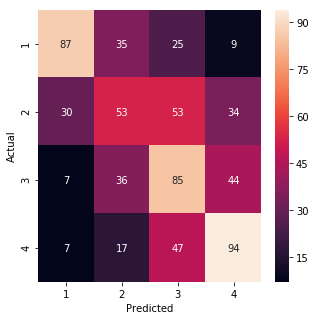

In [210]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_class)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True,
            yticklabels=['1', '2','3','4'], xticklabels=['1','2','3','4'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### False positives are quite numerous particularly for class 2 and 3

### Additional reporting for figuring out which features are best predictors

In [69]:
from scipy import stats
import statsmodels.formula.api as sm

In [70]:
#modelsmdata = pd.read_csv('data_MCF_combined.csv',encoding='iso-8859-1')
#modelsmdata['combreqrole'] = modelsmdata['RoleResponsibility'] + modelsmdata['Requirements']

In [82]:
templist = []
for row in model1train['combreqrole']:
    row = row.encode('ascii', 'ignore').decode('ascii')
    templist.append(row)
print templist


[u'About Singapore Institute for Clinical Sciences (SICS) Established in 2007, the Singapore Institute for Clinical Sciences (SICS) is a research institute within the Agency for Science, Technology and Research (A*STAR), and its mission is to develop clinical and translational research programmes in key disease areas. SICS is distinguished by its focus on clinical sciences and the use of innovative approaches and technologies that enable the efficient and effective study of human health and diseases. The clinical scientists in SICS conduct the full spectrum of bench to bedside research activities in metabolic diseases (including diabetes, obesity and insulin resistance), pathways to normal growth and development (including cognitive and behavioural development), and nutritional sciences. The institute aims to attract, train and nurture clinician-scientists and to develop joint programmes with universities, academic medical centres, government hospitals and research institutes. For more

In [83]:
len(templist)

883

In [84]:
X_train3 = pd.DataFrame(vect.transform(templist).todense(),
                      columns=vect.get_feature_names())
#X_train3 = X_train3.decode('ascii', 'ignore')
y_train3 = model1train['salarycategory']

In [85]:
X_train3.head()

,000,000 clients,000 clients 100,000 employees,000 employees serving,000 employees working,000 patients,000 patients 2017,000 people,000 people åê,...,ûû,ûû requirements,ûû requirements degree,ûû åê,ûü,ûü ûüwe,ûü ûüwe invite,ûüwe,ûüwe invite,ûüwe invite people
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
tempsmpd = pd.concat([X_train3, y_train3], axis=1, ignore_index=False)

In [87]:
tempsmpd.head()

,000,000 clients,000 clients 100,000 employees,000 employees serving,000 employees working,000 patients,000 patients 2017,000 people,000 people åê,...,ûû requirements,ûû requirements degree,ûû åê,ûü,ûü ûüwe,ûü ûüwe invite,ûüwe,ûüwe invite,ûüwe invite people,salarycategory
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [88]:
smmodel = sm.logit(X_train3, y_train3)

UnicodeEncodeError: 'ascii' codec can't encode characters in position 11-12: ordinal not in range(128)

In [ ]:
smdata.summary()

### Problems with encoding cannot be resolved in time so skipping the statsmodel scoring for now

### FINAL STEP for PART 1: Using best model and predicting salaries on job postings with no salaries

In [191]:
model1test['combreqrole'] = model1test['roleresp'] + model1test['requirements']

In [192]:
model1test.head()

,index,companyname,jobtitle,location,employmenttype,seniority,category,roleresp,requirements,combreqrole
10,10,BLUECHIP PLATFORMS ASIA PTE. LTD.,Data analyst - global wealth management (contr...,South,Full Time,Senior Executive,Information Technology,"Develop and implement databases, data collecti...",Minimum Degree At least 3 years of Data rela...,"Develop and implement databases, data collecti..."
12,12,BEACON CONSULTING PTE LTD,Temp Admin (Data Analytics),Central,Permanent ...,Executive,Information Technology,Temp Admins are required for a Data Analytics ...,Proficient in Microsoft Excel (data tabulatio...,Temp Admins are required for a Data Analytics ...
18,18,BLUECHIP PLATFORMS ASIA PTE. LTD.,"Data analyst, reference data (contract)",Central,Full Time,Professional ...,Information Technology,"Established for over 80 years, the Client is a...",At least 3 years of Data related experience w...,"Established for over 80 years, the Client is a..."
38,38,Health Promotion Board,"Senior Manager / Manager, Data Management",Central,Full Time,Professional,Building and Construction ...,Job Responsibilities \r\rManage internal and e...,-,Job Responsibilities \r\rManage internal and e...
47,47,GRABTAXI HOLDINGS PTE. LTD.,data scientist,Central,Permanent,Senior Management,Advertising / Media ...,Get to know our Team: åÊ GrabÛªs Data Science...,"The must haves: Ph.D. graduate, or Masters(wi...",Get to know our Team: åÊ GrabÛªs Data Science...


In [193]:
X_testt = model1test['combreqrole'].values

In [194]:
y_pred_classfinal = log.predict(vect.transform(X_testt))

In [196]:
model1test['predictedsalcat'] = y_pred_classfinal

In [197]:
model1test.head()

,index,companyname,jobtitle,location,employmenttype,seniority,category,roleresp,requirements,combreqrole,predictedsalcat
10,10,BLUECHIP PLATFORMS ASIA PTE. LTD.,Data analyst - global wealth management (contr...,South,Full Time,Senior Executive,Information Technology,"Develop and implement databases, data collecti...",Minimum Degree At least 3 years of Data rela...,"Develop and implement databases, data collecti...",1
12,12,BEACON CONSULTING PTE LTD,Temp Admin (Data Analytics),Central,Permanent ...,Executive,Information Technology,Temp Admins are required for a Data Analytics ...,Proficient in Microsoft Excel (data tabulatio...,Temp Admins are required for a Data Analytics ...,1
18,18,BLUECHIP PLATFORMS ASIA PTE. LTD.,"Data analyst, reference data (contract)",Central,Full Time,Professional ...,Information Technology,"Established for over 80 years, the Client is a...",At least 3 years of Data related experience w...,"Established for over 80 years, the Client is a...",2
38,38,Health Promotion Board,"Senior Manager / Manager, Data Management",Central,Full Time,Professional,Building and Construction ...,Job Responsibilities \r\rManage internal and e...,-,Job Responsibilities \r\rManage internal and e...,3
47,47,GRABTAXI HOLDINGS PTE. LTD.,data scientist,Central,Permanent,Senior Management,Advertising / Media ...,Get to know our Team: åÊ GrabÛªs Data Science...,"The must haves: Ph.D. graduate, or Masters(wi...",Get to know our Team: åÊ GrabÛªs Data Science...,4


### Visual inspection of predicted salary categories looks intuitively correct

## Proceeding to Part 2

### Loading and cleaning the data (different dataset without salaries from jobscentral)

In [128]:
model2data = pd.read_csv('updjobscdata.csv',encoding='utf-8')

In [129]:
model2data.shape

(1033, 5)

In [130]:
model2data.head()

,Description,Requirements,Title,Company,Date
0,ACCOUNTS ASSISTANT • Accounting functions cove...,"[Permanent, Entry Level, Experienced, Accounti...",ACCOUNTS ASSISTANT,NAKAJIMA SUISAN (ASIA) PTE LTD,Posted: 18-Apr-2018
1,European MNC5 days work weekWest - Transportat...,"[Permanent, Experienced, Clerical/Admin, ...",Senior HR Executive (Full Spectrum of HR Dutie...,TODAY'S CAREER,Posted: 29-Mar-2018
2,Job ResponsibilitiesDevelop and implement mach...,"[Permanent, Entry Level, Experienced, Automoti...",Software Engineer (Machine Learning) (KXR/RIS/...,Singapore Technologies Kinetics Ltd,Posted: 19-Apr-2018
3,TD integration support for assisting engineers...,"[Permanent, Contract, Entry Level, Diploma, Ba...",Intern NVM LOGIC 1,GLOBALFOUNDRIES Singapore Pte. Ltd.,Posted: 16-Apr-2018
4,The RoleAdmin support to Department of Nursing...,"[Permanent, Experienced, Clerical/Admin, ...",Senior / Executive,Parkway Pantai Limited,Posted: 22-Mar-2018


In [131]:
model2data['Requirements'].isnull().sum()

606

### Doing some initial analysis on the commonly recurring phrases in the job titles to determine what to try to predict

In [132]:
# doing some initial analysis on the commonly recurring phrases in the job titles
vect = CountVectorizer(lowercase=True)
tempmatrix = vect.fit_transform(model2data.Title)

In [133]:
sum_words = tempmatrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)

[(u'engineer', 236),
 (u'assistant', 223),
 (u'admin', 163),
 (u'senior', 127),
 (u'executive', 126),
 (u'temp', 90),
 (u'manager', 88),
 (u'contract', 88),
 (u'months', 86),
 (u'to', 77),
 (u'up', 62),
 (u'officer', 59),
 (u'engineering', 50),
 (u'ref', 49),
 (u'process', 48),
 (u'data', 44),
 (u'fab', 41),
 (u'hr', 40),
 (u'service', 39),
 (u'sales', 38),
 (u'analyst', 37),
 (u'and', 34),
 (u'development', 33),
 (u'customer', 33),
 (u'healthcare', 32),
 (u'equipment', 31),
 (u'module', 31),
 (u'eng', 30),
 (u'accounts', 30),
 (u'mnc', 28),
 (u'management', 28),
 (u'associate', 27),
 (u'days', 27),
 (u'marketing', 27),
 (u'immediate', 26),
 (u'business', 26),
 (u'integration', 25),
 (u'coordinator', 25),
 (u'operations', 24),
 (u'east', 24),
 (u'administrative', 24),
 (u'fab10', 23),
 (u'office', 23),
 (u'it', 23),
 (u'support', 23),
 (u'2000', 23),
 (u'administrator', 23),
 (u'year', 23),
 (u'yield', 23),
 (u'project', 22),
 (u'system', 22),
 (u'technician', 22),
 (u'1800', 21),
 (u'

### Classification is to be done in relation to the following keywords associated with seniority:
### Senior
### Assistant
### Executive

### Preparing target features

In [134]:
# create new feature for titles containing senior
tempsen = model2data[model2data.Title.str.contains('Senior') == True]
tempsen['seniority'] = 1
tempsen1 = model2data[model2data.Title.str.contains('Senior') == False]
tempsen1['seniority'] = 0

tempsen2 = pd.concat([tempsen, tempsen1], axis=0, ignore_index=True)

# # create new feature for titles containing scientist
# tempsci = model2data[model2data.Title.str.contains('Scientist') == True]
# tempsci['scientist'] = 1

# # create new feature for titles containing analyst
# tempana = model2data[model2data.Title.str.contains('Analyst') == True]
# tempana['analyst'] = 1

# # combining subsets of data
# model2data = pd.concat([tempsen, tempsci, tempana], axis=0, ignore_index=True)

# # filling up remaining values to indicate 0
# model2data.fillna(value=0, inplace=True)

C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [135]:
# create new feature for titles containing assistant
tempass = tempsen2[tempsen2.Title.str.contains('Assistant') == True]
tempass['assistant'] = 1
tempass1 = tempsen2[tempsen2.Title.str.contains('Assistant') == False]
tempass1['assistant'] = 0

tempass2 = pd.concat([tempass, tempass1], axis=0, ignore_index=True)

C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [136]:
# create new feature for titles containing executive
tempexe = tempass2[tempass2.Title.str.contains('Executive') == True]
tempexe['executive'] = 1
tempexe1 = tempass2[tempass2.Title.str.contains('Executive') == False]
tempexe1['executive'] = 0

model2data = pd.concat([tempexe, tempexe1], axis=0, ignore_index=True)

C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\arb_b\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Preparing predictor features

In [142]:
# combining the two columns with the greatest amount of text
model2data['combdecreq'] = model2data['Requirements'] + model2data['Description']

In [143]:
model2data.shape

(1033, 9)

In [144]:
# some trial value counts
model2data['Requirements'].isnull().sum()

606

In [145]:
model2data.head()

,Description,Requirements,Title,Company,Date,seniority,assistant,executive,combdecreq
0,The ChallengesEnsure operational aspects in te...,"[Permanent, Contract, Experienced, Manager, Cl...","Senior Executive / Assistant Manager, Operatio...",National University Hospital,Posted: 27-Feb-2018,1,1,1,"[Permanent, Contract, Experienced, Manager, Cl..."
1,Administrative activitiesManage a wide variety...,"[Permanent, Contract, Entry Level, Experienced...",Junior/ Senior Executive Assistant (Medical In...,Recruit Express Pte Ltd,Posted: 7-Apr-2018,1,1,1,"[Permanent, Contract, Entry Level, Experienced..."
2,Responsibilities:The incumbent is a driven ind...,NaN,"Senior Executive / Assistant Manager, Business...",,Posted: 13-Apr-2018,1,1,1,NaN
3,Responsibilties:Responsible for planning and m...,NaN,Senior Executive / Assistant Manager (Student ...,,Posted: 13-Apr-2018,1,1,1,NaN
4,"Duties include, but are not limited to:Provide...","[Permanent, Contract, Entry Level, Experienced...","Executive Assistant (Healthcare, Medical Indus...",Recruit Express Pte Ltd,Posted: 24-Mar-2018,0,1,1,"[Permanent, Contract, Entry Level, Experienced..."


## Proceeding to do actual modelling

In [146]:
# predictors for senior vs non-senior
y = model2data.seniority
X = model2data.Description

In [147]:
# baseline calculation
model2data['seniority'].value_counts()

0    914
1    119
Name: seniority, dtype: int64

In [148]:
914/float(len(model2data['seniority']))
# baseline ~ 88.4%

0.8848015488867377

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.8)

In [150]:
vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range=(1,3))
X_train2 = vect.fit_transform(X_train)
X_test2 = vect.transform(X_test)

In [151]:
# using logistic regression to predict senior vs non-senior
log = LogisticRegression()
log.fit(X_train2, y_train)
y_pred_class = log.predict(X_test2)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)
# results are worse than baseline

0.8778718258766627


In [152]:
# test printing last 50 features to see why results are so bad
print vect.get_feature_names()[-50:]

[u'yms ace', u'yms ace xp', u'yong', u'yong cei', u'yong cei registration', u'yong chiu', u'yong chiu kuan', u'yong joeyor', u'yong joeyor joey', u'yong joeyplease', u'yong joeyplease include', u'yong kian', u'yong kian fung', u'yong qing', u'yong qing r1551295', u'young', u'young adults', u'young adults teenagerslively', u'youwill', u'youwill compute', u'youwill compute employee', u'youyou', u'youyou aspiring', u'youyou aspiring professional', u'yrs', u'yrs exp', u'yrs exp required', u'yu', u'yu qing', u'yu qing recruit', u'yuan', u'yuan qirecruitment', u'yuan qirecruitment consultantrecruit', u'yummydurian', u'yummydurian com', u'yummydurian comjob', u'yummydurian comjob duties', u'yummydurian comkey', u'yummydurian comkey area', u'zero', u'zero defects', u'zero defects engage', u'zero safety', u'zero safety cases', u'zero safety environment', u'zero waste', u'zero waste mindset', u'zoning', u'zoning lun', u'zoning lun masking']


In [153]:
# predictors for assistant vs non-assistant
y = model2data.assistant
X = model2data.Description

In [154]:
# baseline calculation
model2data['assistant'].value_counts()

0    808
1    225
Name: assistant, dtype: int64

In [155]:
808/float(len(model2data['assistant']))
# baseline ~ 78.2%

0.782187802516941

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.8)

In [157]:
vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range=(1,2))
X_train2 = vect.fit_transform(X_train)
X_test2 = vect.transform(X_test)

In [158]:
# using logistic regression to predict assistant vs non-assistant
log = LogisticRegression()
log.fit(X_train2, y_train)
y_pred_class = log.predict(X_test2)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)
# some promise here since this was higher than baseline

0.8367593712212817


In [159]:
# predictors for executive vs non-executive
y = model2data.executive
X = model2data.Description

In [160]:
# baseline calculation
model2data['executive'].value_counts()

0    922
1    111
Name: executive, dtype: int64

In [161]:
922/float(len(model2data['executive']))
# baseline ~ 78.2%

0.8925459825750242

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.8)

In [163]:
vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range=(1,3))
X_train2 = vect.fit_transform(X_train)
X_test2 = vect.transform(X_test)

In [164]:
# using logistic regression to predict executive vs non-executive
log = LogisticRegression()
log.fit(X_train2, y_train)
y_pred_class = log.predict(X_test2)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)
# once again this is lower than baseline

0.8851269649334945


### Results were not very good overall, so doing some resampling for the 'Assistant' tag which appeared to have the best prospects

In [165]:
from sklearn.utils import resample

In [166]:
model2datanass = model2data[model2data['assistant']==0]
model2dataass = model2data[model2data['assistant']==1]

In [167]:
df_majority_downsampled = resample(model2datanass, 
                                 replace=False,    # sample without replacement
                                 n_samples=225,     # to match assistant class of 225
                                 random_state=123)
# combining both dataframes to create single dataframe again
model2dataresampled = pd.concat([df_majority_downsampled, model2dataass])
model2dataresampled['assistant'].value_counts()

1    225
0    225
Name: assistant, dtype: int64

In [ ]:
# imb-learn

In [168]:
# redefine x and y
# predictors for assistant vs non-assistant
y = model2dataresampled.assistant
X = model2dataresampled.Description

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.8)

In [170]:
vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range=(1,3))
X_train3 = vect.fit_transform(X_train)
X_test3 = vect.transform(X_test)

In [171]:
# using logistic regression to predict assistant vs non-assistant again
log = LogisticRegression()
log.fit(X_train3, y_train)
y_pred_class = log.predict(X_test3)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.7583333333333333


### This is about a 50% improvement over the new baseline of 50% which seems acceptable

### Determining best/worst indicative features for 'Assistant' job titles

In [172]:
docs1 = pd.DataFrame(abs(log.coef_),
                   columns=vect.get_feature_names()).sum()
   
docs1.sort_values(ascending=False).head(10)

sales             0.160016
email             0.157704
duties            0.134399
administrative    0.130175
levels            0.128746
process           0.106593
technical         0.100969
production        0.099439
customer          0.095934
management        0.093615
dtype: float64

In [173]:
docs1.sort_values(ascending=True).head(10)

culture                    0.000012
engineering relevant       0.000015
human resources            0.000025
programmes                 0.000033
keywords                   0.000067
platforms                  0.000092
science engineering req    0.000114
engineering req            0.000114
engineering req id         0.000114
duty                       0.000118
dtype: float64

### Some additional scoring metrics

In [174]:
print(metrics.classification_report(y_test, y_pred_class,target_names=['assistant','non-assistant']))

               precision    recall  f1-score   support

    assistant       0.84      0.65      0.73       183
non-assistant       0.71      0.87      0.78       177

  avg / total       0.77      0.76      0.76       360



In [175]:
conmat = metrics.confusion_matrix(y_test, y_pred_class)

confusion = pd.DataFrame(conmat, index=['is_assistant','is_ non-assistant'],columns=['pred_assistant','pred_non-assistant'])
confusion

,pred_assistant,pred_non-assistant
is_assistant,119,64
is_ non-assistant,23,154


### Summarised findings will be listed in the executive summary

## That's all folks!!!